In [1]:
from templates import * 
from us_classifier_model import *

/home/demir/anaconda3/envs/env-diffae/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda'
conf = mixed_us_training()
# print(conf.name)
model = LitModel(conf)
state = torch.load(R'/home/demir/Desktop/diffae_checkpoints/epoch=250AmiroCroppedCosine.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device)

Global seed set to 0


Model params: 91.89 M


BeatGANsAutoencModel(
  (time_embed): TimeStyleSeperateEmbed(
    (time_embed): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (style): Identity()
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=128, bias=True)
        )
        (cond_emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=64, bias=True)
     

In [7]:
cls_model = USSimPredictor(512, 1)
cls_model.load_state_dict(torch.load(R'/home/demir/Desktop/diffae_checkpoints/classifiers/us_sim_predictor_BCE_last.pth'))
cls_model.to(device)

USSimPredictor(
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

In [3]:
simulated_dataset = CrawlerDataset(R'/home/demir/Desktop/diffae-datasets/source_train_cropped')
real_dataset = CrawlerDataset(R'/home/demir/Desktop/diffae-datasets/target_train_cropped')

simulated_loader = DataLoader(simulated_dataset, batch_size=16, shuffle=False, num_workers=0)
real_loader = DataLoader(real_dataset, batch_size=16, shuffle=False, num_workers=0)

In [4]:
print('# simulated images: ', len(simulated_dataset))
print('# real images: ', len(real_dataset))

# simulated images:  6670
# real images:  7866


In [9]:
batch = simulated_dataset[0]['img'][None]

torch.Size([1, 1, 128, 128])

In [10]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=1000)

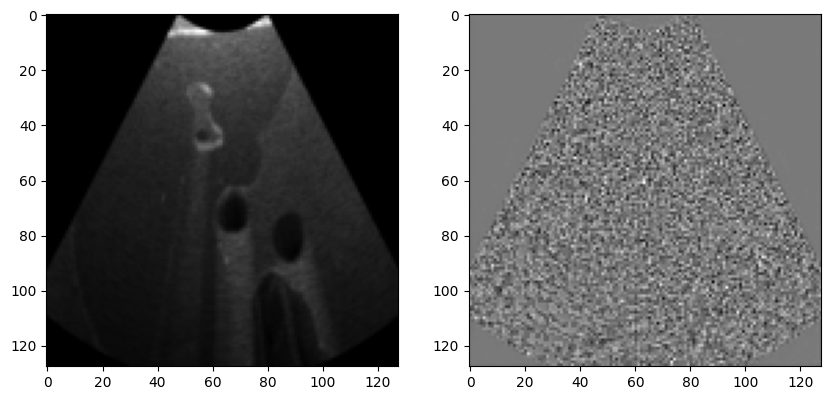

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(batch[0].permute(1, 2, 0).cpu(), cmap='gray')
ax[1].imshow(xT[0].permute(1, 2, 0).cpu(), cmap='gray')

In [17]:
conds_mean = -0.1568
conds_std = 0.4709

cond2 = (cond - conds_mean) / conds_std
cond2 = cond2 + 0.1 * math.sqrt(512) * F.normalize(cls_model.fc.weight[0][None, :], dim=1)
cond2 = (cond2 * conds_std) + conds_mean

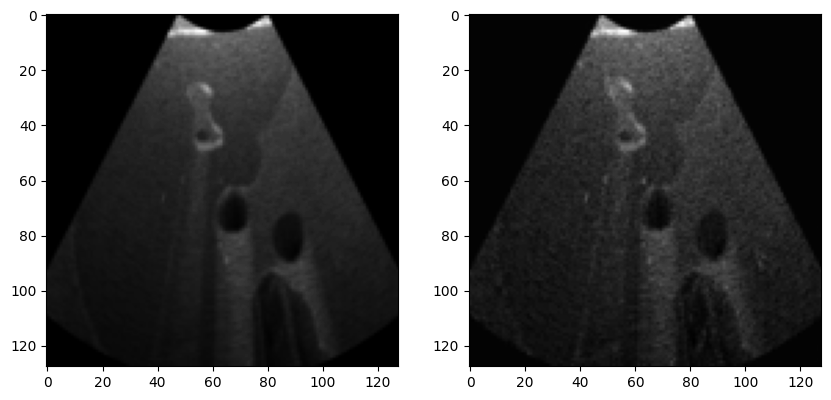

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
img = model.render(xT, cond2, T=1000)
ax[0].imshow(batch[0].permute(1, 2, 0).cpu(), cmap='gray')
ax[1].imshow(img[0].permute(1, 2, 0).cpu(), cmap='gray')
plt.show()